Importing Libraries to be used in the notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

# libraries for NLP
from nltk.corpus import stopwords
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# libraries to check model metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score

from xgboost import XGBClassifier

# Loading Dataset

In [2]:
# Importing train and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test_with_no_labels.csv')
display(train_df.head())
display(test_df.head())


,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


# Exploratory Data Analysis 

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


The dataset contains three features
- the dataset consist of `15819` rows
- there seems to be no null values


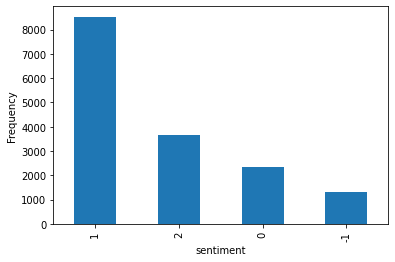

In [4]:
train_df.sentiment.value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xlabel('sentiment');

In [98]:
# Class count
pro_Climate, news_Fact, neutral, anti_Climate = train_df.sentiment.value_counts()

In [99]:
# Divide by class
neutral_df = train_df[train_df['sentiment']==0]
anti_Climate_df = train_df[train_df['sentiment']==-1]
pro_Climate_df = train_df[train_df['sentiment']==1]
news_Fact_df = train_df[train_df['sentiment']==2]

In [119]:
# As usual, we start by importing our modules
from sklearn.utils import resample

Random under-sampling:
 0    8530
-1    8530
 2    8530
 1    8530
Name: sentiment, dtype: int64


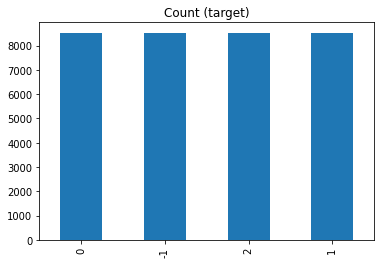

In [120]:
neutral_df_over = resample(neutral_df,
                          replace=True, # sample without replacement (no need to duplicate observations)
                          n_samples=pro_Climate, # match number in minority class
                          random_state=27)

anti_Climate_df_over = resample(anti_Climate_df,
                          replace=True, # sample without replacement (no need to duplicate observations)
                          n_samples=pro_Climate, # match number in minority class
                          random_state=27)
news_Fact_df_over = resample(news_Fact_df,
                          replace=True, # sample without replacement (no need to duplicate observations)
                          n_samples=pro_Climate, # match number in minority class
                          random_state=27)

df_test_over = pd.concat([neutral_df_over, anti_Climate_df_over, news_Fact_df_over, pro_Climate_df], axis=0)

print('Random under-sampling:')
print(df_test_over.sentiment.value_counts())

df_test_over.sentiment.value_counts().plot(kind='bar', title='Count (target)');

In [117]:
# neutral_df_over = neutral_df.sample(news_Fact, replace=True)
# anti_Climate_df_over = anti_Climate_df.sample(news_Fact, replace=True)
# pro_Climate_df_over = pro_Climate_df.sample(news_Fact)
# df_test_over = pd.concat([neutral_df_over, anti_Climate_df_over, pro_Climate_df_over, news_Fact_df], axis=0)

# print('Random under-sampling:')
# print(df_test_over.sentiment.value_counts())

# df_test_over.sentiment.value_counts().plot(kind='bar', title='Count (target)');

Most tweets support the man-made climate change which is represented by `1` while we have a fewer anti-climate change tweets

# Data Cleaning and Wrangling 

### Creating a function to clean the `message`

In [5]:
# sentiment_list
sentiment_list = ['Neutral', 'Anti-Climate', 'Pro-Climate','News-Fact']

In [6]:
# # creating a function to stem each words
stemmer = SnowballStemmer('english')
# creating a function to lemmatize each words
lemmatizer = WordNetLemmatizer()

In [121]:
# creating a function
def cleaning(tweet):
    pattern = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    rem_link = re.sub(pattern, '', tweet)
    rem_punct = re.sub(r'[^a-zA-Z ]', '', rem_link)
    rem_punct = re.sub(r'RT', '', rem_punct)
    word_split = rem_punct.lower().split()
    stops = set(stopwords.words("english"))
    without_stop_sent = ' '.join([t for t in word_split if t not in stops])
    return without_stop_sent

df_test_over['cleaned_tweet'] = df_test_over.message.apply(cleaning)

In [122]:
def stemmer_fn(words, stemmer):
    word_split = set(words.split())
    return ' '.join([stemmer.stem(word) for word in word_split])

df_test_over['stem_tweet'] = df_test_over.cleaned_tweet.apply(stemmer_fn, args=(stemmer, ))

In [123]:
def lemmatizer_fn(words, lemmatizer):
    word_split = set(words.split())
    return ' '.join([lemmatizer.lemmatize(word) for word in word_split])

df_test_over['lemma_tweet'] = df_test_over['cleaned_tweet'].apply(lemmatizer_fn, args=(lemmatizer, ))

In [124]:
df_test_over.head()

,sentiment,message,tweetid,cleaned_tweet,stem_tweet,lemma_tweet
6841,0,"RT @kady: Don't worry, people can now start co...",937757,kady dont worry people start complaining took ...,chang start new worri two peopl dont year appo...,change start new worry two people dont year ap...
4894,0,"Gold's gone, many other minerals almost gone, ...",364120,golds gone many minerals almost gone weve rest...,import sought chang restrict miner mani hardwo...,import sought change restricted mineral many h...
8696,0,@GlblCtzn dont fight climate change everyone u...,201783,glblctzn dont fight climate change everyone un...,chang everyon fight planet glblctzn understand...,change everyone fight planet glblctzn understa...
906,0,What do you guys think of Trump's stance on cl...,558046,guys think trumps stance climate change global...,chang guy global warm think climat stanc trump,change guy global warming think climate stance...
6741,0,An upside to climate change is that I'm wearin...,816243,upside climate change im wearing shorts tshirt...,chang wear short novemb climat tshirt upsid im,change wearing short november climate tshirt u...


In [128]:
# vectorize
vectorizer = CountVectorizer(analyzer = "word",
                             min_df=2,
#                              max_df = 0.5,
#                              ngram_range=(1, 5),
                             max_features = None) 

In [129]:
reviews_vect = vectorizer.fit_transform(df_test_over['lemma_tweet'])

In [130]:
train_data_features = reviews_vect.toarray() # for fast fitting of our dataset
train_data_features.shape

(34120, 13795)

In [131]:
y = np.array(df_test_over['sentiment'])
X = train_data_features

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [132]:
def modelling(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, coln_index=None):
    model.fit(X_train, y_train)
    pred_lm = model.predict(X_test)
    # Plotting confusion matrix
    cm = confusion_matrix(y_test, pred_lm)
    cm_df = pd.DataFrame(cm, index = sentiment_list, columns = sentiment_list)
    cr_df = pd.DataFrame(classification_report(y_test, pred_lm, target_names=sentiment_list, output_dict=True))
    
    #Plotting the confusion matrix
    plt.figure(figsize=(10,5))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    
    print('Confusion Matrix')
    display(cm_df)
    print('Classification Report')
    display(cr_df)
    
    return cm_df, cr_df

[LibLinear]

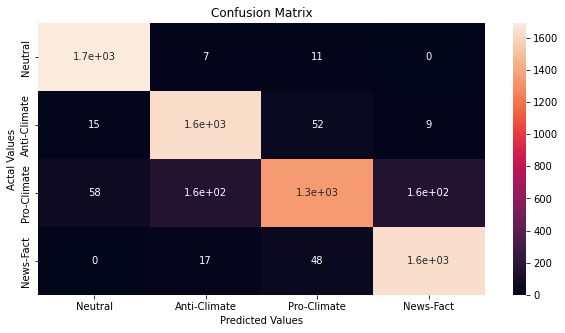

Confusion Matrix


,Neutral,Anti-Climate,Pro-Climate,News-Fact
Neutral,1691,7,11,0
Anti-Climate,15,1627,52,9
Pro-Climate,58,156,1342,155
News-Fact,0,17,48,1636


Classification Report


,Neutral,Anti-Climate,Pro-Climate,News-Fact,accuracy,macro avg,weighted avg
precision,0.958617,0.900387,0.923606,0.908889,0.922626,0.922875,0.922911
recall,0.989468,0.955373,0.784337,0.961787,0.922626,0.922741,0.922626
f1-score,0.973798,0.927066,0.848293,0.934590,0.922626,0.920937,0.920894
support,1709.000000,1703.000000,1711.000000,1701.000000,0.922626,6824.000000,6824.000000


In [133]:
# create logistic regression model instance
lm = LogisticRegression(C=2, penalty='l2', solver='liblinear', verbose=1)
cm_df, cr_df = modelling(lm,  coln_index=sentiment_list)

In [77]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

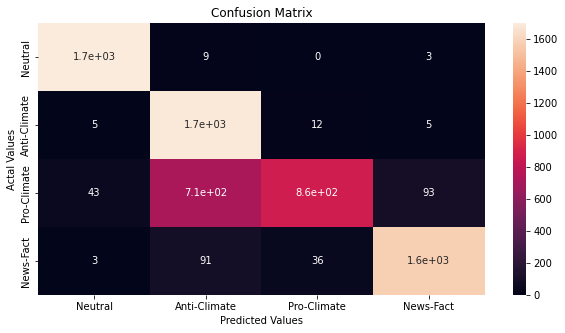

Confusion Matrix


,Neutral,Anti-Climate,Pro-Climate,News-Fact
Neutral,1697,9,0,3
Anti-Climate,5,1681,12,5
Pro-Climate,43,712,863,93
News-Fact,3,91,36,1571


Classification Report


,Neutral,Anti-Climate,Pro-Climate,News-Fact,accuracy,macro avg,weighted avg
precision,0.970824,0.674288,0.947311,0.939593,0.8517,0.883004,0.883140
recall,0.992978,0.987082,0.504383,0.923574,0.8517,0.852004,0.851700
f1-score,0.981776,0.801239,0.658276,0.931515,0.8517,0.843202,0.843081
support,1709.000000,1703.000000,1711.000000,1701.000000,0.8517,6824.000000,6824.000000


In [78]:
n_neighbors = 1 # <--- change this number to play around with how many nearest neighbours to look for.

knn = KNeighborsClassifier(n_neighbors)
cm_df, cr_df = modelling(knn,  coln_index=sentiment_list)

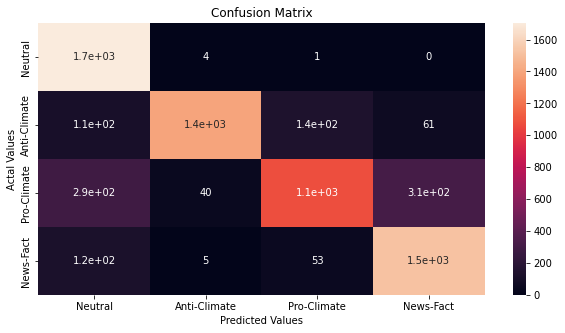

Confusion Matrix


,Neutral,Anti-Climate,Pro-Climate,News-Fact
Neutral,1704,4,1,0
Anti-Climate,109,1394,139,61
Pro-Climate,286,40,1075,310
News-Fact,122,5,53,1521


Classification Report


,Neutral,Anti-Climate,Pro-Climate,News-Fact,accuracy,macro avg,weighted avg
precision,0.767222,0.966043,0.847792,0.803911,0.834408,0.846242,0.846187
recall,0.997074,0.818555,0.628288,0.894180,0.834408,0.834524,0.834408
f1-score,0.867176,0.886205,0.721719,0.846646,0.834408,0.830436,0.830336
support,1709.000000,1703.000000,1711.000000,1701.000000,0.834408,6824.000000,6824.000000


In [79]:
naive_bayes = GaussianNB()
cm_df, cr_df = modelling(naive_bayes,  coln_index=sentiment_list)

#### Cleaning the test dataset

In [134]:
test_df['cleaned_tweet'] = test_df.message.apply(cleaning)
test_df['lemma_tweet'] = test_df['cleaned_tweet'].apply(lemmatizer_fn, args=(lemmatizer, ))
test_df['stem_tweet'] = test_df.cleaned_tweet.apply(stemmer_fn, args=(stemmer, ))

In [135]:
test_df

,message,tweetid,cleaned_tweet,lemma_tweet,stem_tweet
0,Europe will now be looking to China to make su...,169760,europe looking china make sure alone fighting ...,change sure looking europe make fighting clima...,chang sure look europ make fight climat china ...
1,Combine this with the polling of staffers re c...,35326,combine polling staffers climate change womens...,polling change woman combine fascist state cli...,poll chang women combin fascist state climat s...
2,"The scary, unimpeachable evidence that climate...",224985,scary unimpeachable evidence climate change al...,change evidence itstimetochange already climat...,chang evid itstimetochang alreadi climat unimp...
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,karoli morgfair osborneink dailykos putin got ...,change think hoax got putin dailykos jill osbo...,chang think hoax got putin dailyko jill osborn...
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,fakewillmoore female orgasms cause global warm...,orgasm global republican cause fakewillmoore f...,orgasm global republican caus fakewillmoor fem...
...,...,...,...,...,...
10541,"RT @BrittanyBohrer: Brb, writing a poem about ...",895714,brittanybohrer brb writing poem climate change...,change writing science brb climate brittanyboh...,chang write scienc brb climat brittanybohr poe...
10542,2016: the year climate change came home: Durin...,875167,year climate change came home hottest year rec...,change karl home came mathiesen year record cl...,chang karl home came mathiesen year record cli...
10543,RT @loop_vanuatu: Pacific countries positive a...,78329,loopvanuatu pacific countries positive fiji le...,change positive global loopvanuatu leading nov...,chang posit global loopvanuatu lead novemb cli...
10544,"RT @xanria_00018: You’re so hot, you must be t...",867455,xanria youre hot must cause global warming ald...,hot global must warming jophie xanria cause al...,hot global must warm jophi xanria caus aldubla...


In [136]:
reviews_vect_test = vectorizer.transform(test_df['lemma_tweet'])

In [137]:
test_data_features = reviews_vect_test.toarray() # for fast fitting of our dataset
test_data_features.shape

(10546, 13795)

In [138]:
lm = LogisticRegression(C=2, penalty='l2', solver='liblinear', verbose=1)
lm.fit(X_train, y_train)
pred_lm = lm.predict(test_data_features)

[LibLinear]

In [139]:
# Saving test predictions to file
output = pd.DataFrame({'tweetid': test_df.tweetid,
                       'sentiment': pred_lm})
output.to_csv('submission.csv', index=False)